In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from salishsea_tools import (tidetools, geo_tools, viz_tools)
import numpy.ma as ma
import pandas as pd
import datetime
import pytz
import os
%matplotlib inline

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)

In [3]:
mesh = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')

In [4]:
HINDCAST_PATH= '/results/SalishSea/nowcast-green/'

In [5]:
f = pd.read_excel('/ocean/eolson/MEOPAR/obs/PSFCitSci/Chla_2015PSFSalish_Sea_22.01.2018vers_8_CN_edits.xls',header=6)

In [6]:
f.keys()

Index(['Date sampled (mm/dd/yyyy)', 'Station Name', 'Time of Day (Local)',
       'Latitude', 'Longitude', 'Depth', 'Chl a', 'Phaeophytin', 'Comments'],
      dtype='object')

In [7]:
f = f.drop(f.index[[0]])
f.shape

(137, 9)

In [8]:
f = f.dropna(subset = ['Date sampled (mm/dd/yyyy)', 'Time of Day (Local)', 
                   'Latitude', 'Longitude', 'Depth', 'Chl a'])

In [9]:
f.shape

(51, 9)

In [10]:
local = pytz.timezone ("America/Los_Angeles")

In [11]:
f.loc[f['Date sampled (mm/dd/yyyy)'] == '07/15//2015', 'Date sampled (mm/dd/yyyy)'] = '07/15/2015'

In [12]:
f.loc[f['Date sampled (mm/dd/yyyy)'] == '05/23//2015', 'Date sampled (mm/dd/yyyy)'] = '05/23/2015'
f.loc[f['Date sampled (mm/dd/yyyy)'] == '05/17//2015', 'Date sampled (mm/dd/yyyy)'] = '05/17/2015'

In [13]:
f['Date sampled (mm/dd/yyyy)'].values

array(['09/16/2015', '09/14/2015', '08/09/2015', '06/16/2015',
       '06/23/2015', '04/19/2015', '07/01/2015', '08/06/2015',
       '06/24/2015', '07/15/2015', '05/10/2015', '06/14/2015',
       '05/18/2015', '06/24/2015', '07/01/2015', '07/15/2015',
       '06/24/2015', '07/15/2015', '08/06/2015', '07/16/2015',
       '05/23/2015', '06/07/2015', '05/13/2015', '05/17/2015',
       '05/09/2015', '04/19/2015', '04/19/2015', '05/25/2015',
       '06/09/2015', '05/11/2015', '05/18/2015', '05/25/2015',
       '06/09/2015', '05/11/2015', '05/18/2015', '05/26/2015',
       datetime.datetime(2015, 8, 6, 0, 0), '05/11/2015', '05/19/2015',
       '05/25/2015', '07/02/2015', datetime.datetime(2015, 1, 7, 0, 0),
       '08/06/2015', '08/15/2015', '06/10/2015', '05/25/2015',
       '04/18/2015', '06/15/2015', '06/15/2015', '06/15/2015', '05/26/2015'], dtype=object)

In [14]:
f['Latitude'].unique()[0][4:]

'44.200'

In [15]:
list_of_lons = np.array([])
list_of_lats = np.array([])
list_of_datetimes = np.array([])
list_of_cs_chl = np.array([])
list_of_model_chl = np.array([])
list_of_depths = np.array([])
for n in f.index:
    decLat = float(f.Latitude[n][:2]) + float(f['Latitude'][n][4:])/60
    decLon = (float(f.Longitude[n][:3]) + float(f['Longitude'][n][5:])/60) * -1
    Yind, Xind = geo_tools.find_closest_model_point(decLon, decLat, 
                                                    X, Y, land_mask = bathy.mask)
    depth = 0
    if mesh.variables['tmask'][0,depth,Yind, Xind] == 1:
        try:
            local_datetime = datetime.datetime.combine(datetime.datetime.strptime(
                f['Date sampled (mm/dd/yyyy)'][n], '%m/%d/%Y'),f['Time of Day (Local)'][n])
        except (TypeError):
            local_datetime = (datetime.datetime.combine(f['Date sampled (mm/dd/yyyy)'][n],
                                                        f['Time of Day (Local)'][n]))
        date = local.localize(local_datetime, is_dst=True).astimezone(pytz.utc)
        if date.minute < 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                               hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
            sub_dir = before.strftime('%d%b%y').lower()
            datestr = before.strftime('%Y%m%d')
            fname = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr, datestr)
            nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
            after = before + datetime.timedelta(hours=1)
            sub_dir2 = after.strftime('%d%b%y').lower()
            datestr2 = after.strftime('%Y%m%d')
            fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
            nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
            delta = (date.minute + 30) / 60
            chl_val = 1.6*((1-delta)*(nuts.variables['diatoms'][before.hour, depth, Yind, Xind] 
                           + nuts.variables['ciliates'][before.hour,depth,Yind, Xind] 
                           + nuts.variables['flagellates'][before.hour,depth,Yind,Xind]) + 
                       (delta)*(nuts2.variables['diatoms'][after.hour, depth, Yind, Xind] 
                           + nuts2.variables['ciliates'][after.hour,depth,Yind, Xind] 
                           + nuts2.variables['flagellates'][after.hour,depth,Yind,Xind]))
        if date.minute >= 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                   hour = (date.hour), minute = 30)
            sub_dir = before.strftime('%d%b%y').lower()
            datestr = before.strftime('%Y%m%d')
            fname = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr, datestr)
            nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
            after = before + datetime.timedelta(hours=1)
            sub_dir2 = after.strftime('%d%b%y').lower()
            datestr2 = after.strftime('%Y%m%d')
            fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
            nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
            delta = (date.minute) / 60
            chl_val = 1.6*(delta*(nuts.variables['diatoms'][before.hour, depth, Yind, Xind] 
                           + nuts.variables['ciliates'][before.hour,depth,Yind, Xind] 
                           + nuts.variables['flagellates'][before.hour,depth,Yind,Xind]) + 
                       (1- delta)*(nuts2.variables['diatoms'][after.hour, depth, Yind, Xind] 
                           + nuts2.variables['ciliates'][after.hour,depth,Yind, Xind] 
                           + nuts2.variables['flagellates'][after.hour,depth,Yind,Xind]))
        list_of_lons = np.append(list_of_lons, decLon)
        list_of_lats = np.append(list_of_lats, decLat)
        list_of_datetimes = np.append(list_of_datetimes, date)
        list_of_cs_chl = np.append(list_of_cs_chl, f['Chl a'][n])
        list_of_model_chl = np.append(list_of_model_chl, chl_val)
        list_of_depths = np.append(list_of_depths, depth)

In [20]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titlesize'] = 12

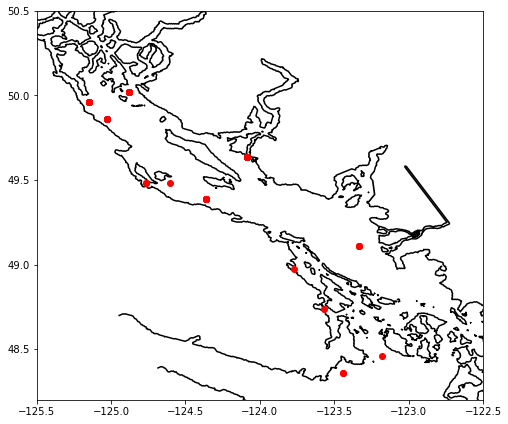

In [17]:
fig, ax = plt.subplots(figsize = (8,8))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(list_of_lons, list_of_lats, 'ro')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(48.2, 50.5)
ax.set_xlim(-125.5, -122.5);

In [18]:
list_of_cs_chl.shape

(51,)

bias =  3.60188791615
RMSE = 5.14038381616
Willmott = 0.206609060708


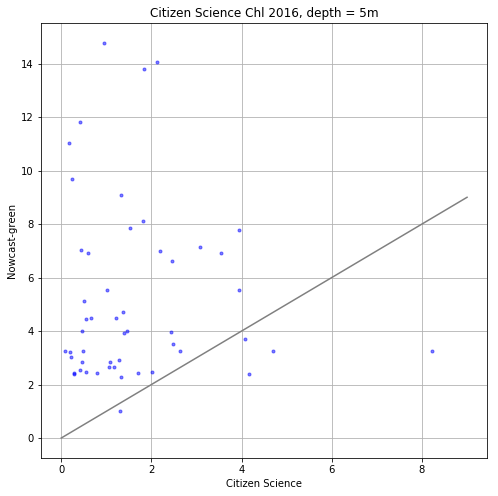

In [19]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(list_of_cs_chl, list_of_model_chl,  'b.', alpha = 0.5)
ax.plot(np.arange(0,10), color = 'grey')
ax.grid('on')
ax.set_title('Citizen Science Chl 2016, depth = 5m')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green');
print('bias =  ' + str(-np.mean(list_of_cs_chl) + np.mean(list_of_model_chl)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_chl - list_of_cs_chl)**2) /
                              len(list_of_cs_chl))))
xbar = np.mean(list_of_cs_chl)
print('Willmott = ' + str(1-(np.sum((list_of_model_chl - list_of_cs_chl)**2)  / 
                             np.sum((np.abs(list_of_model_chl - xbar) 
                                     + np.abs(list_of_cs_chl - xbar))**2))))

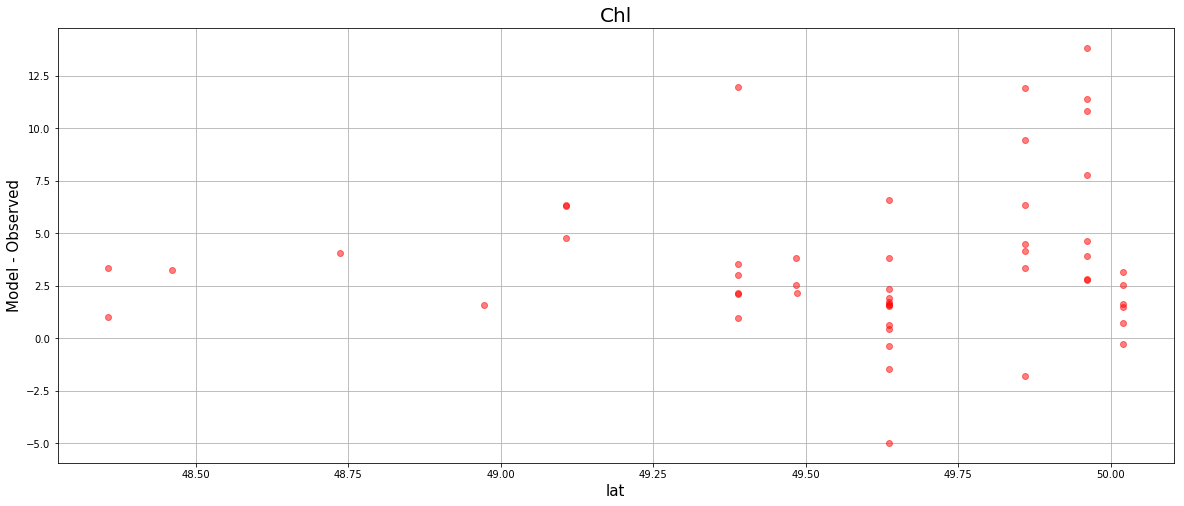

In [20]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_lats, list_of_model_chl - list_of_cs_chl, 'ro', alpha =0.5)
ax.grid('on')
ax.set_xlabel('lat', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Chl', fontsize = 20)

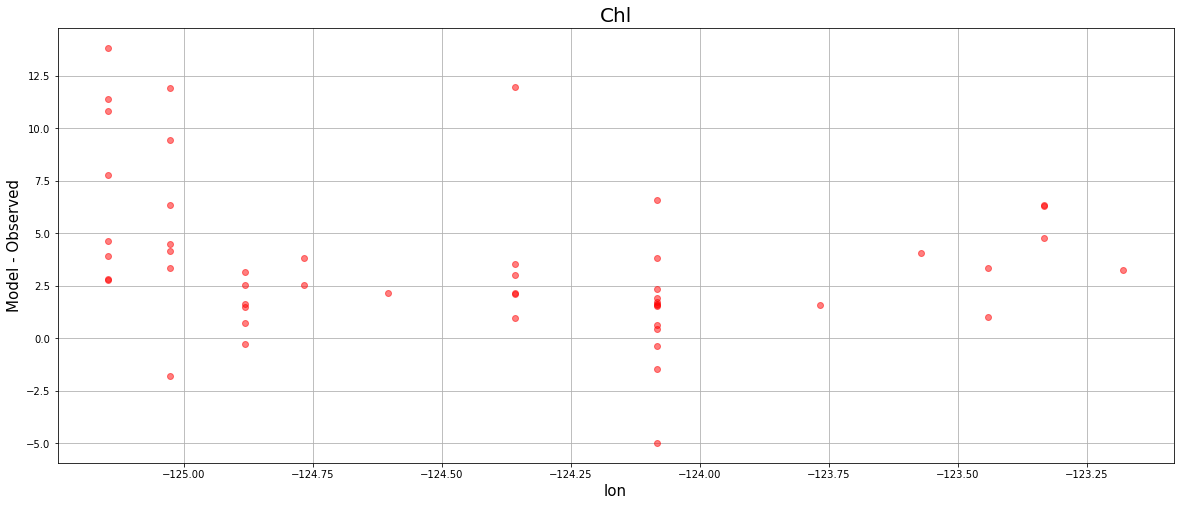

In [21]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_lons, list_of_model_chl - list_of_cs_chl, 'ro', alpha =0.5)
ax.grid('on')
ax.set_xlabel('lon', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Chl', fontsize = 20)

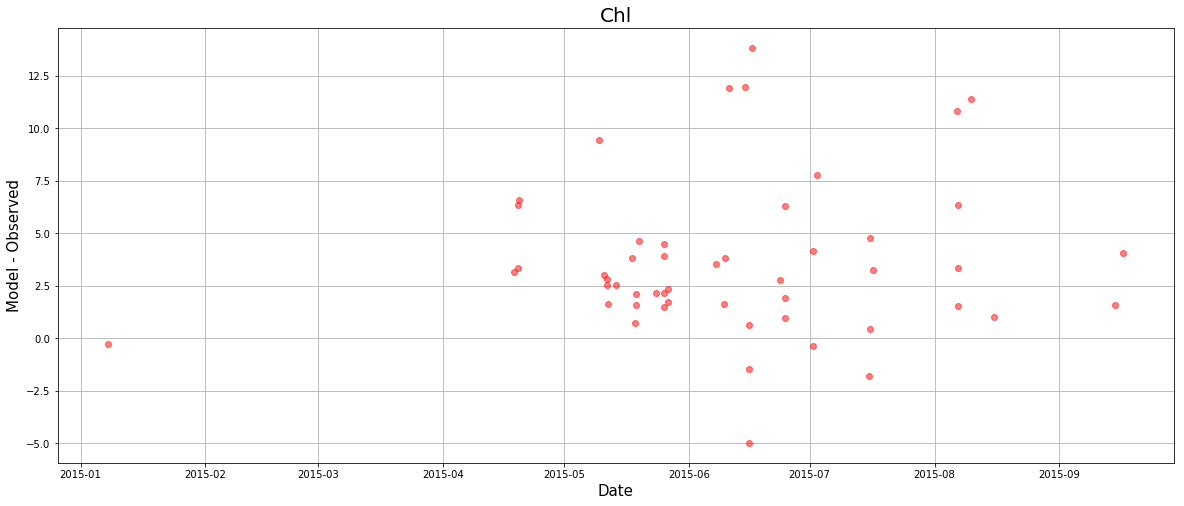

In [22]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_datetimes, list_of_model_chl - list_of_cs_chl, 'ro', alpha =0.5)
ax.grid('on')
ax.set_xlabel('Date', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Chl', fontsize = 20)